# Install Detectron2 Dependencies

In [1]:
# Instalando dependencias: (Sempre use cu101 porque o colab utiliza CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8 MB 22 kB/s 
     |████████████████████████████████| 6.6 MB 19.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.5.0+cu101 which is incompatible.
     |████████████████████████████████| 274 kB 5.2 MB/s 
  Created wheel fo

In [2]:
# Instalação do Detectron 2:
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.5/index.html
     |████████████████████████████████| 6.2 MB 769 kB/s 
     |████████████████████████████████| 49 kB 2.9 MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60944 sha256=8a5352d44ecdf6e76853cc1c4b0ef18903421d22a37d14e4773ed1654faafb92
  Stored in directory: /root/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
Successfully built fvcore


In [3]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

# Import and Register Custom Detectron2 Data

In [4]:
!curl -L "https://app.roboflow.com/ds/1UX2Wu3Vkr?key=JfRkhSZGNY" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   887  100   887    0     0   1979      0 --:--:-- --:--:-- --:--:--  1979
100 38.8M  100 38.8M    0     0  51.3M      0 --:--:-- --:--:-- --:--:-- 51.3M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/_annotations.coco.json  
 extracting: test/image10_jpg.rf.2c9c18b0df8b2ead98347852aaafaeea.jpg  
 extracting: test/image15_jpg.rf.e1f0ba0bd9024fc431ac3c2522876243.jpg  
 extracting: test/image16_jpg.rf.00082b0a9306bbd39297db8ef24de3f1.jpg  
 extracting: test/image16_jpg.rf.06e062e0ad47597a793f0d894988e82b.jpg  
 extracting: test/image17_jpg.rf.a0fb8900c8eded963d3cb1c360ee2610.jpg  
 extracting: test/image19_jpg.rf.4f15c5262a85af84704a58c0326da66a.jpg  
 extracting: test/image20_jpg.rf.d79d34650653a29334a7c6845650554f.jpg  
 extracting: test/i

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/train/_annotations.coco.json", "/content/train")
register_coco_instances("my_dataset_val", {}, "/content/valid/_annotations.coco.json", "/content/valid")
register_coco_instances("my_dataset_test", {}, "/content/test/_annotations.coco.json", "/content/test")


WARNING [01/18 16:02:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/18 16:02:35 d2.data.datasets.coco]: Loaded 732 images in COCO format from /content/train/_annotations.coco.json


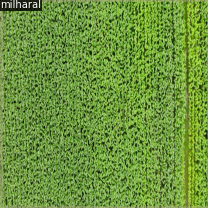

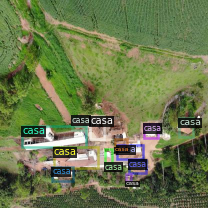

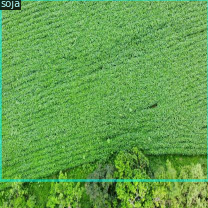

In [6]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Train Custom Detectron2 Detector

In [7]:
#We are importing our own Trainer Module here to use the COCO validation evaluation during training. Otherwise no validation eval occurs.

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator

class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [ ]:
#from .detectron2.tools.train_net import Trainer
#from detectron2.engine import DefaultTrainer
# select from modelzoo here: https://github.com/facebookresearch/detectron2/blob/master/MODEL_ZOO.md#coco-object-detection-baselines

from detectron2.config import get_cfg
#from detectron2.evaluation.coco_evaluation import COCOEvaluator
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05




cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4 #your number of classes + 1

cfg.TEST.EVAL_PERIOD = 500


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[01/18 16:02:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_68b088.pkl: 421MB [00:07, 55.8MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (5, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (5,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

[01/18 16:02:52 d2.engine.train_loop]: Starting training from iteration 0
[01/18 16:04:29 d2.utils.events]:  eta: 2:00:21  iter: 19  total_loss: 1.986  loss_cls: 1.747  loss_box_reg: 0.020  loss_rpn_cls: 0.151  loss_rpn_loc: 0.016  time: 4.8229  data_time: 0.0328  lr: 0.000020  max_mem: 7236M
[01/18 16:06:07 d2.utils.events]:  eta: 2:02:56  iter: 39  total_loss: 1.527  loss_cls: 1.116  loss_box_reg: 0.000  loss_rpn_cls: 0.122  loss_rpn_loc: 0.019  time: 4.8627  data_time: 0.0148  lr: 0.000040  max_mem: 7236M
[01/18 16:07:45 d2.utils.events]:  eta: 2:01:51  iter: 59  total_loss: 0.829  loss_cls: 0.627  loss_box_reg: 0.138  loss_rpn_cls: 0.047  loss_rpn_loc: 0.017  time: 4.8795  data_time: 0.0181  lr: 0.000060  max_mem: 7236M
[01/18 16:09:23 d2.utils.events]:  eta: 2:00:31  iter: 79  total_loss: 0.536  loss_cls: 0.489  loss_box_reg: 0.000  loss_rpn_cls: 0.016  loss_rpn_loc: 0.012  time: 4.8885  data_time: 0.0145  lr: 0.000080  max_mem: 7236M
[01/18 16:10:59 d2.utils.events]:  eta: 1:58:3

In [ ]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

<IPython.core.display.Javascript object>

In [ ]:
#test evaluation
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [01/18 18:06:22 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[01/18 18:06:22 d2.data.datasets.coco]: Loaded 35 images in COCO format from /content/test/_annotations.coco.json
[01/18 18:06:22 d2.data.build]: Distribution of instances among all 8 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|  cafezal   | 0            |  cafezal   | 4            |   carro    | 2            |
|    casa    | 51           |  estrada   | 2            |  milharal  | 7            |
|   pasto    | 18           |    soja    | 6            |            |              |
|   total    | 90           |            |              |            |              |
[01/18 18:06:22 d2.data.common]: Serializing 35 elements to byte tensors and concatenating them all ...
[01/18 18:06:22 d2.data.common]: Serialized da

OrderedDict([('bbox',
              {'AP': 6.37743550750841,
               'AP-cafezal': 2.9249872418189256,
               'AP-carro': 21.44271570014144,
               'AP-casa': 20.27434561059849,
               'AP-estrada': 0.0,
               'AP-milharal': 0.0,
               'AP-pasto': 0.0,
               'AP-soja': 0.0,
               'AP50': 13.016897720055384,
               'AP75': 4.928607023189153,
               'APl': 0.48648762835467224,
               'APm': 35.30842081213588,
               'APs': 20.214356360368306})])

# Inference with Detectron2 Saved Weights



In [ ]:
%ls ./output/

coco_instances_results.json                       last_checkpoint
events.out.tfevents.1642521764.ae4a9430768c.73.0  metrics.json
instances_predictions.pth                         model_final.pth


In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.DATASETS.TEST = ("my_dataset_test", )
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
predictor = DefaultPredictor(cfg)
test_metadata = MetadataCatalog.get("my_dataset_test")

In [ ]:
from detectron2.utils.visualizer import ColorMode
import glob

for imageName in glob.glob('/content/test/*jpg'):
  im = cv2.imread(imageName)
  outputs = predictor(im)
  v = Visualizer(im[:, :, ::-1],
                metadata=test_metadata, 
                scale=0.8
                 )
  out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
  cv2_imshow(out.get_image()[:, :, ::-1])
